In [93]:
import os
import sys
import random
from datetime import datetime


sys.path.append('../src')

from design_gene_blocks import DesignEblocks
from design_IVA_primers import DesignPrimers
from snapgene_output import SnapGeneOutput

# !pip3 install openpyxl

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
# TODO THERE IS NO DIFFERENCE BETWEEN OPTIMIZATION COST AND AMONT!?!? CHECK THIS

In [123]:
# TODO Add image of the vector
# https://www.biotite-python.org/examples/gallery/sequence/plasmid_map_custom.html

In this tutorial we will randomly design a number of mutations for the replicative DNA polymerase DnaE1 from *Mycobacterium smegmatis* to better understand it's function. <br>

The expression plasmid containing Msmeg DnaE1 is XXX and is stored in XXX. <br>

Gene from mycobrowser XXX and is stored in XXX <br>

In [124]:
# File locations for input and output

vector = 'files/snapgene_vector.dna' # TODO Change name and change vector (see snapgene computer which one to take)
msmeg_dnae1 = 'files/A0QX55.fasta'  # M. smegmatis DnaE1 gene
gene_name = "Msmeg DnaE1"
output_location = 'output/'  # Location to store the files created in this notebook
codon_usage = 'Mycobacterium Smegmatis' # We want to use the codon usage of this organism
codon_usage_fp = r"C:\Users\Rosan\Documents\git\my_repositories\design_gene_blocks\src\data\codon_usage" # Location of the codon usage files
optimize = 'cost'

First we open the nucleotide sequence of Msmeg DnaE1 and translate this to the protein sequence. Here, the start and stop codon are not translated 

In [125]:
# Load the nucleotide sequence

msmeg_dnae1_dna = DesignEblocks.read_seq(msmeg_dnae1)
print("Nucleotide sequence: ", msmeg_dnae1_dna)

# Translate nucleotide to protein sequence

msmeg_dnae1_protein = msmeg_dnae1_dna.translate()
print("Protein sequence: ", msmeg_dnae1_protein)

# Create a list of all DnaE1 residues

msmeg_dnae1_residues = [i + str(j) for i, j in zip(msmeg_dnae1_protein, range(1, len(msmeg_dnae1_protein) + 1))]
print("Residues: ", msmeg_dnae1_residues)

Nucleotide sequence:  atgagcggttcatctgcggggtcctccttcgtgcacctgcacaaccacaccgagtattcgatgctggacggtgccgcgaagatcacgcccatgctcgccgaggtggagcggctggggatgcccgcggtggggatgaccgaccacggaaacatgttcggtgccagcgagttctacaactccgcgaccaaggccgggatcaagccgatcatcggcgtggaggcatacatcgcgccgggctcgcggttcgacacccggcgcatcctgtggggtgaccccagccaaaaggccgacgacgtctccggcagcggctcctacacgcacctgacgatgatggccgagaacgccaccggtctgcgcaacctgttcaagctgtcctcgcatgcttccttcgagggccagctgagcaagtggtcgcgcatggacgccgagctcatcgccgaacacgccgagggcatcatcatcaccaccggatgcccgtcgggggaggtgcagacccgcctgcggctcggccaggatcgggaggcgctcgaagccgcggcgaagtggcgggagatcgtcggaccggacaactacttccttgagctgatggaccacgggctgaccatcgaacgccgggtccgtgacggtctgctcgagatcggacgcgcgctcaacattccgcctcttgccaccaatgactgccactacgtgacccgcgacgccgcccacaaccatgaggctttgttgtgtgtgcagaccggcaagaccctctcggatccgaatcgcttcaagttcgacggtgacggctactacctgaagtcggccgccgagatgcgccagatctgggacgacgaagtgccgggcgcgtgtgactccaccttgttgatcgccgaacgggtgcagtcctacgccgacgtgtggacaccgcgcgaccggatgcccgtgtttccggtgcccgatgggcatgaccaggcgtcctggctgcgtcacgaggtggac

Now we will randomly design some mutations for this gene. Here, we will not generate any mutations in the N- or C- terminal region, to ensure we can create a 20bp overlap with the beginning or end of the gene in our eBlock design <br>

1. **Single point mutations** <br>

Single point mutations contain a single mutation per eBlock

2. **Multiple point mutations in same eBlock**

Multiple point mutations contain multiple mutations in the same eBlock

3. **Inserts**

Inserts contain addition of amino acids in the eBlock

4. **Deletions**

Deletions have parts of the gene deleted

In [126]:
# List containing all natural amino acids and options for our mutations
choices = ['A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'S', 'T', 'N', 'Q', 'C', 'G', 'P', 'R', 'H', 'K', 'D', 'E']

# Set of functions to randomly select mutations and insertions/deletions

def random_single_mutation(residues, choices, n):
    """
    Randomly select single mutations in a protein sequence.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    choices : list
        List of all natural amino acids
    n : int
        Number of mutations to sample
    """
    res = random.sample(residues, n)
    mut = random.sample(choices, n)
    mutants = [i + j for i, j in zip(res, mut)]
    return mutants


def random_multiple_mutation(residues, choices, n, max_distance_between_mutants=5, max_number_mutations=4):
    """
    Randomly select multiple mutations in a protein sequence that will be combined in one mutant.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    choices : list
        List of all natural amino acids
    n : int
        Number of mutations to sample
    max_distance_between_mutants : int
        Maximum distance (in residues) between the two mutations, default is set to 10
    """
    mutants = []  # List to store the mutants
    res1 = random.sample(residues, n)
    var1=  random.sample(choices, n)
    mut1 = [i + j for i, j in zip(res1, var1)]
    for i in mut1:
        temp_muts = []
        num_mutations = random.sample(range(1, max_number_mutations), 1)[0]
        pos_x = random.sample(range(1, max_distance_between_mutants), num_mutations)
        vars_x = random.sample(choices, num_mutations)
        for j, k in zip(pos_x, vars_x):
            mut_x = residues[int(i[1:-1]) + j] + k
            temp_muts.append(mut_x)
        mutants.append(i + '-' + '-'.join(temp_muts))
    return mutants


def random_insert(residues, choices, n, max_length_insertion=10):
    """
    Randomly generate insertions in a protein sequence.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    choices : list
        List of all natural amino acids
    n : int
        Number of insertions to sample
    max_length_insertion : int 
        Maximum length of the insertion, default is set to 10
    """
    inserts = []  # List to store the inserts
    for i in range(n):
        len_insertion = random.sample(range(1, max_length_insertion), 1)[0]
        insertion = random.sample(choices, len_insertion)
        insertion = ''.join(insertion)
        residue = random.sample(residues, 1)[0]
        insert = residue + '-' + insertion
        inserts.append(insert)
    return inserts


def random_deletion(residues, n, max_length_deletion=10):
    """
    Randomly generate deletions in a protein sequence.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    n : int
        Number of deletions to sample
    max_length_deletion : int
        Maximum length of the deletion, default is set to 10
    """
    deletions = []
    for i in range(n):
        len_deletion = random.sample(range(1, max_length_deletion), 1)[0]
        res_b = random.sample(residues, 1)[0]
        res_e = residues[residues.index(res_b) + len_deletion]
        deletion = res_b + '-' + res_e
        deletions.append(deletion)
    return deletions

In [127]:
# TODO FIX INDEX ERROR (INDEX OUT OF RANGE) FOR DOUBlE MUTATIONS

# Randomly select single mutations
number_single = 20
selected_single_mutants = random_single_mutation(msmeg_dnae1_residues[25:-25], choices, number_single)
print(f"Generated {number_single} single mutations: ", selected_single_mutants)

# Randomly select double mutations
number_double = 2
selected_double_mutants = random_multiple_mutation(msmeg_dnae1_residues[25:-25], choices, number_double)
print(f"Generated {number_double} paired mutations: ", selected_double_mutants)

# Randomly select insertions
number_insertions = 2
selected_insertions = random_insert(msmeg_dnae1_residues[25:-25], choices, number_insertions)
print(f"Generated {number_insertions} insertions: ", selected_insertions)

# Randomly select deletions
number_deletions = 2
selected_deletions = random_deletion(msmeg_dnae1_residues[25:-25], number_deletions)
print(f"Generated {number_deletions} deletions: ", selected_deletions)

total_number_mutations = number_single + number_double + number_insertions + number_deletions
print(f"Total number of mutations: {total_number_mutations}")

Generated 20 single mutations:  ['T224W', 'E184E', 'Y859T', 'Y58N', 'C158S', 'L217R', 'H919K', 'R1135L', 'T1139F', 'S1115P', 'I689I', 'A931G', 'D47Y', 'R322Q', 'G740C', 'V817H', 'E150V', 'L367M', 'H236D', 'N218A']
Generated 2 paired mutations:  ['A530K-L560K-A557H-P559N', 'T957F-L986K-E984M-M985E']
Generated 2 insertions:  ['V1018-YDCG', 'V843-MDKHVC']
Generated 2 deletions:  ['T482-A484', 'R832-I836']
Total number of mutations: 26


In [128]:
# Formatting the mutations in a format that can be read by the DesignEblocks class, see documentation for more information about this

now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H:%M")
mutationsfile = f'files/mutations_random_Msmeg_DnaE1_N{total_number_mutations}_{dt_string}.txt'

with open(mutationsfile, 'w') as f:
    for i in selected_single_mutants:
        f.write(i + '\n')
    for i in selected_double_mutants:
        f.write('Combined ' + i + '\n')
    for i in selected_insertions:
        f.write('Insert ' + i + '\n')
    for i in selected_deletions:
        f.write('Deletion ' + i + '\n')

Now that we have selected the mutations that we want to create, we can start the design of the eBlocks. <br>
First, we create an instance of the DesignEblocks class and provide the information. Next we will start the design of the eBlocks. <br>
<br>

TODO: Describe the steps that are carried out in this class

In [129]:
# Create instance of DesignEblocks to design the eBlocks per mutation

eBlocks_instance = DesignEblocks(
                        sequence_fp=msmeg_dnae1,
                        gene_name=gene_name,
                        mutations_fp=mutationsfile,
                        optimize='cost', # Optimize for the cost of the eBlocks (default) 'cost', or for the number of eBlocks 'amount'
                        output_fp=output_location,
                        species=codon_usage,
                        codon_usage_fp=codon_usage_fp)

<AxesSubplot: >

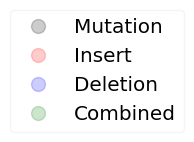

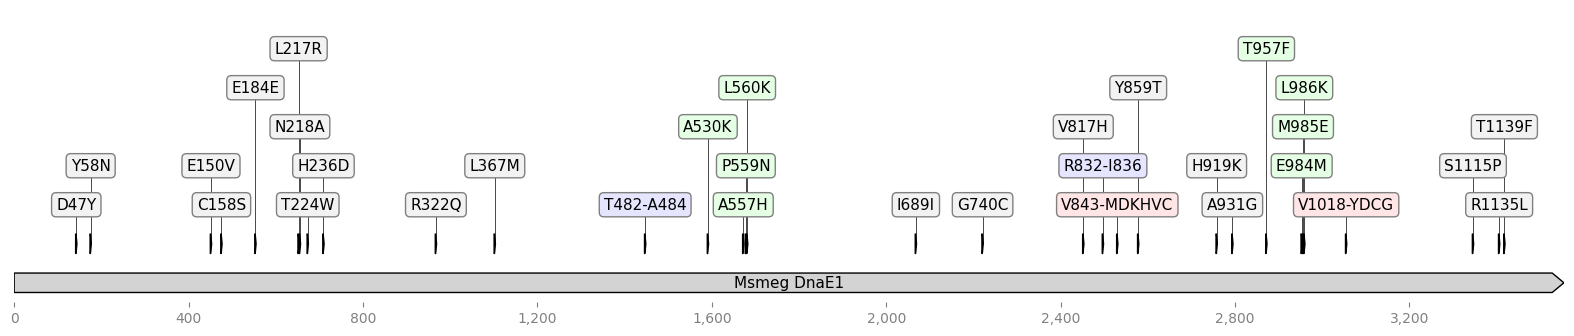

In [130]:
# First, lets take a look at the mutations that we have selected

# TODO Maybe change colors of every double mutant, to see if they are in the same region to distinguish between them

record, legend = eBlocks_instance.plot_eblocks_mutations(idx_dna_tups=None, eblocks=False, mutations=True, genename=eBlocks_instance.gene_name)
record.plot(figure_width=20)[0]

In the above plot we can view the mutations and how they are divided over the gene. Now we let the program design the eBlock regions in such a way that as many mutations as possible are put on the same eBlock.

paired:  [(1590, 1680, 1671, 1677), (2871, 2958, 2952, 2955), (1446, 1449), (2496, 2499, 2502, 2505)]
idx_dna:  [672, 552, 2577, 174, 474, 651, 2757, 3405, 3417, 3345, 2067, 2793, 141, 966, 2220, 2451, 450, 1101, 708, 654, 1590, 1680, 1671, 1677, 2871, 2958, 2952, 2955, 3054, 2529, 1446, 2496]
idx_dna_tups:  [['T224W', 672], ['E184E', 552], ['Y859T', 2577], ['Y58N', 174], ['C158S', 474], ['L217R', 651], ['H919K', 2757], ['R1135L', 3405], ['T1139F', 3417], ['S1115P', 3345], ['I689I', 2067], ['A931G', 2793], ['D47Y', 141], ['R322Q', 966], ['G740C', 2220], ['V817H', 2451], ['E150V', 450], ['L367M', 1101], ['H236D', 708], ['N218A', 654], [['A530K', 1590], ['L560K', 1680], ['A557H', 1671], ['P559N', 1677]], [['T957F', 2871], ['L986K', 2958], ['E984M', 2952], ['M985E', 2955]], ['V1018-YDCG', 3054], ['V843-MDKHVC', 2529], ['T482-A484', 1446], ['R832-I836', 2496]]
idx_test:  [672, 552, 2577, 174, 474, 651, 2757, 3405, 3417, 3345, 2067, 2793, 141, 966, 2220, 2451, 450, 1101, 708, 654, [1590, 16

c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Rosan\A

Block_1_pos_116_991 875
Block_2_pos_1076_2092 1016
Block_3_pos_2195_3442 1247
Designed eBlocks and stored output in  output/


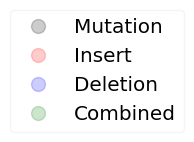

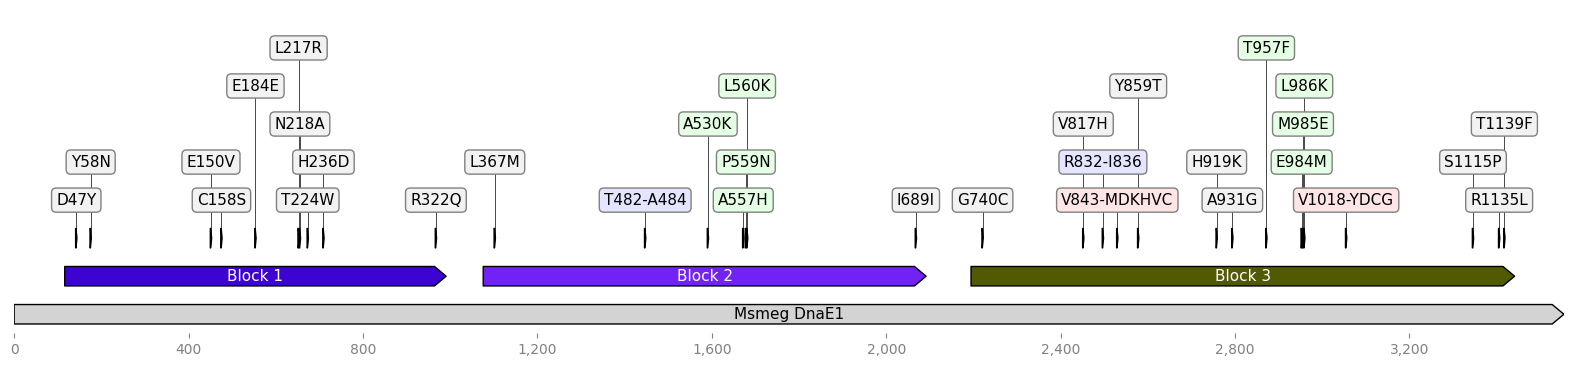

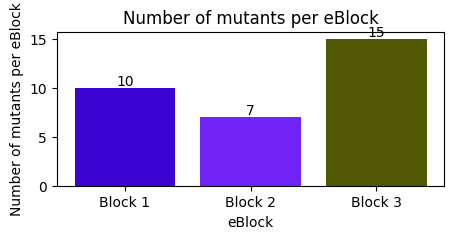

In [131]:
# Run the design of the eBlocks
# TODO Try this tutorial with 100 or 200 mutations as well and see how this affects the plot
# TODO Save the plots of the mutations, barplot and the DNA sequence plot in the output folder

# KMEANS CLUSTERING
# DBSCAN
# MEANSHIFT

eBlocks_instance.run()

paired:  [(1590, 1680, 1671, 1677), (2871, 2958, 2952, 2955), (1446, 1449), (2496, 2499, 2502, 2505)]
idx_dna:  [672, 552, 2577, 174, 474, 651, 2757, 3405, 3417, 3345, 2067, 2793, 141, 966, 2220, 2451, 450, 1101, 708, 654, 1590, 1680, 1671, 1677, 2871, 2958, 2952, 2955, 3054, 2529, 1446, 2496]
idx_dna_tups:  [['T224W', 672], ['E184E', 552], ['Y859T', 2577], ['Y58N', 174], ['C158S', 474], ['L217R', 651], ['H919K', 2757], ['R1135L', 3405], ['T1139F', 3417], ['S1115P', 3345], ['I689I', 2067], ['A931G', 2793], ['D47Y', 141], ['R322Q', 966], ['G740C', 2220], ['V817H', 2451], ['E150V', 450], ['L367M', 1101], ['H236D', 708], ['N218A', 654], [['A530K', 1590], ['L560K', 1680], ['A557H', 1671], ['P559N', 1677]], [['T957F', 2871], ['L986K', 2958], ['E984M', 2952], ['M985E', 2955]], ['V1018-YDCG', 3054], ['V843-MDKHVC', 2529], ['T482-A484', 1446], ['R832-I836', 2496]]
idx_test:  [672, 552, 2577, 174, 474, 651, 2757, 3405, 3417, 3345, 2067, 2793, 141, 966, 2220, 2451, 450, 1101, 708, 654, [1590, 16

c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Rosan\A

Block_1_pos_116_991 875
Block_2_pos_1076_2092 1016
Block_3_pos_2195_3442 1247
Designed eBlocks and stored output in  output/


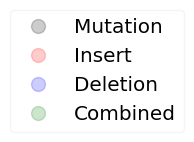

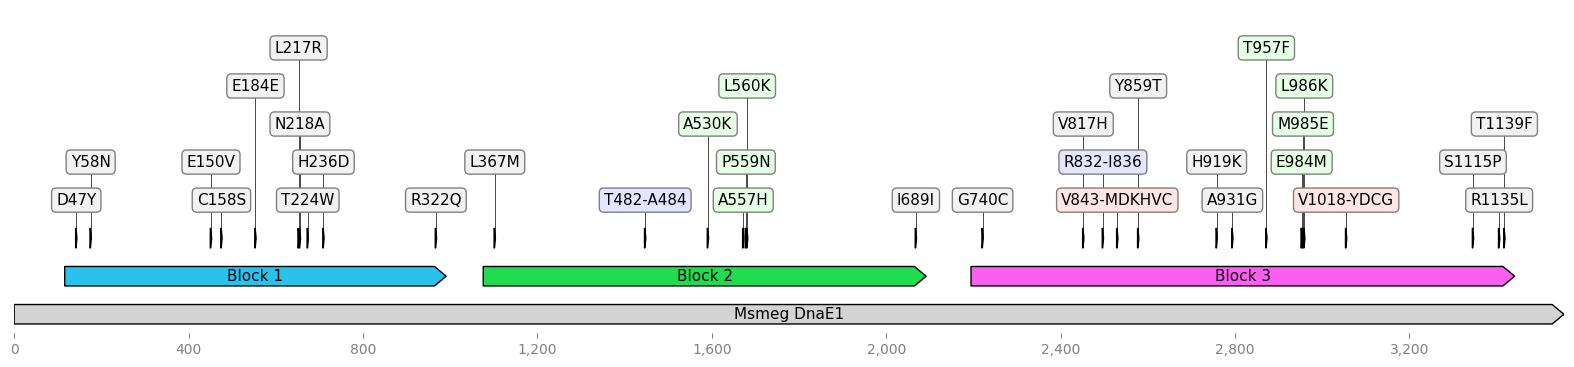

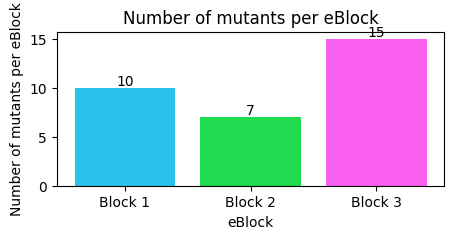

In [132]:
# Now lets do the same but optimize the amount of eBlocks instead of the cost

optimize = 'amount'

eBlocks_instance = DesignEblocks(
                        sequence_fp=msmeg_dnae1,
                        gene_name=gene_name,
                        mutations_fp=mutationsfile,
                        optimize=optimize, # Optimize for the cost of the eBlocks (default) 'cost', or for the number of eBlocks 'amount'
                        output_fp=output_location,
                        species=codon_usage,
                        codon_usage_fp=codon_usage_fp)

eBlocks_instance.run()

In this plot you can see .. how many mutants you can make with an eBlock

In [ ]:
# DESCIBE WHAT OTHER FILES ARE CREATED



In [ ]:
# DECRIBE THE NEXT STEPS

In [133]:
# Next; design IVA primers to open up destination plasmid

mut_gene_blocks_fp = os.path.join(output_location, "mut_gene_blocks.npy")
wt_gene_blocks_fp = os.path.join(output_location, "wt_gene_blocks.npy")

# Create class instance

design_primers = DesignPrimers(wt_gene_blocks_fp=wt_gene_blocks_fp, 
                               mut_gene_blocks_fp=mut_gene_blocks_fp, 
                               output_location=output_location,
                               input_gene_path=gene,
                               snapgene_file=vector)

# Design the primers

design_primers.run()

# Also write results to files that SnapGene can open
primers_fp = os.path.join(output_location, "IVA_primers.csv")
gene_blocks_mutation_info_fp = os.path.join(output_location, "gene_blocks.txt")

# If you have SnapGene installed, you can add the mutations as features in this file

snapgene_output = SnapGeneOutput(wt_gene_blocks_fp = wt_gene_blocks_fp,
                                 mut_gene_blocks_fp = mut_gene_blocks_fp,
                                 primers_fp = primers_fp,
                                 output_location = output_location,
                                 snapgene_file = vector,
                                 gene_blocks_info_fp = gene_blocks_mutation_info_fp)
snapgene_output.run()


NameError: name 'gene' is not defined

In [78]:
# TODO CLEANUP AND REMOVE UNNECCESSARY FILES